In [89]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
# from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve
import joblib
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline


In [90]:
df_vehicules_flotte = pd.read_excel(r"C:\Ai\modele\data\Données Projet Maintenance Flotte.xlsx", sheet_name="VEHICULES - Tableau 1")
df_DT = pd.read_excel(r"C:\Ai\modele\data\Données Historique Maintenance.xlsx", sheet_name="DT")
df_genre= pd.read_excel(r"C:\Ai\modele\data\Données Projet Maintenance Flotte.xlsx", sheet_name="GENRES - Tableau 1")
df_genre = df_genre.rename(columns={"CODE_GENR": "GENRE"})
df_FT = pd.read_excel(r"C:\Ai\modele\data\Données Historique Maintenance.xlsx", sheet_name="FT")
df_kilo = pd.read_excel(r"C:\Ai\modele\data\Kilométrage Parcouru Véhicules.xlsx")

In [91]:

# Grouper par véhicule et sommer le kilométrage
km_total = df_kilo.groupby('CODE_VEHI')['NOMB_UNIT_FONC_NUF'].sum().reset_index()
km_total.columns = ['CODE_VEHI', 'Kilometrage_Total']

# Exporter vers un nouveau fichier Excel
km_total.to_csv("Kilométrage_Total_Par_Véhicule.csv", index=False)

print("Fichier généré avec succès !")

Fichier généré avec succès !


In [92]:
df_fusion1 = pd.merge(df_DT, df_vehicules_flotte, on="CODE_VEHI", how="left")

df_fusion2 = pd.merge(df_fusion1, df_genre, on="GENRE", how="left")

df_fusion3= pd.merge(df_fusion2, df_FT, on="ID_DT", how="left")

df_min=df_fusion3.head()

df = pd.merge(df_fusion3, km_total, on="CODE_VEHI", how="left")
df.to_csv("df.csv", index=False)


In [93]:
df = pd.read_csv("C:\Ai\modele\df.csv")

<>:1: SyntaxWarning: invalid escape sequence '\A'
<>:1: SyntaxWarning: invalid escape sequence '\A'
C:\Users\admin\AppData\Local\Temp\ipykernel_8792\1415896960.py:1: SyntaxWarning: invalid escape sequence '\A'
  df = pd.read_csv("C:\Ai\modele\df.csv")
C:\Users\admin\AppData\Local\Temp\ipykernel_8792\1415896960.py:1: DtypeWarning: Columns (1,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C:\Ai\modele\df.csv")


In [94]:
# Créer la variable cible (1 pour panne, 0 pour maintenance préventive)
df['is_panne'] = df['NATU_INTE_DT'].str.contains('MAINT_CORR', na= False).astype(int)

In [95]:
# Combiner les descriptions textuelles
df['text_description'] = df['TRAV_EFFE_FT'].fillna('') + ' ' + \
                        df['APPA_VISI_FT'].fillna('')
#df['NATU_TRAV_DT'].fillna('') + ' ' + \

# Convertir les dates en datetime
df['DATE_DT'] = pd.to_datetime(df['DATE_DT'])

# Extraire des caractéristiques temporelles
df['month'] = df['DATE_DT'].dt.month
df['dayofweek'] = df['DATE_DT'].dt.dayofweek


# current_year = datetime.datetime.now().year
# df['vehicle_age'] = current_year - pd.to_numeric(df['NUME_IMMA_VEHI'].str.extract('(\d{2})').iloc[:, 0], errors='coerce') + 2000

# # Calculer l'âge du véhicule
import datetime
current_year = datetime.datetime.now().year

# Extraire les deux chiffres avant le premier tiret
# Exemple : "000017-513-22" -> 17
year_2digits = pd.to_numeric(df['NUME_IMMA_VEHI'].str.extract(r'(\d{2})-')[0], errors='coerce')

# Convertir en année complète : 88 -> 1988, 17 -> 2017
def convertir_annee(val):
    if pd.isna(val):
        return None
    val = int(val)
    return 2000 + val if val < 25 else 1900 + val

full_year = year_2digits.apply(convertir_annee)

# Calculer l’âge du véhicule
df['vehicle_age'] = current_year - full_year




Création de visualisations...


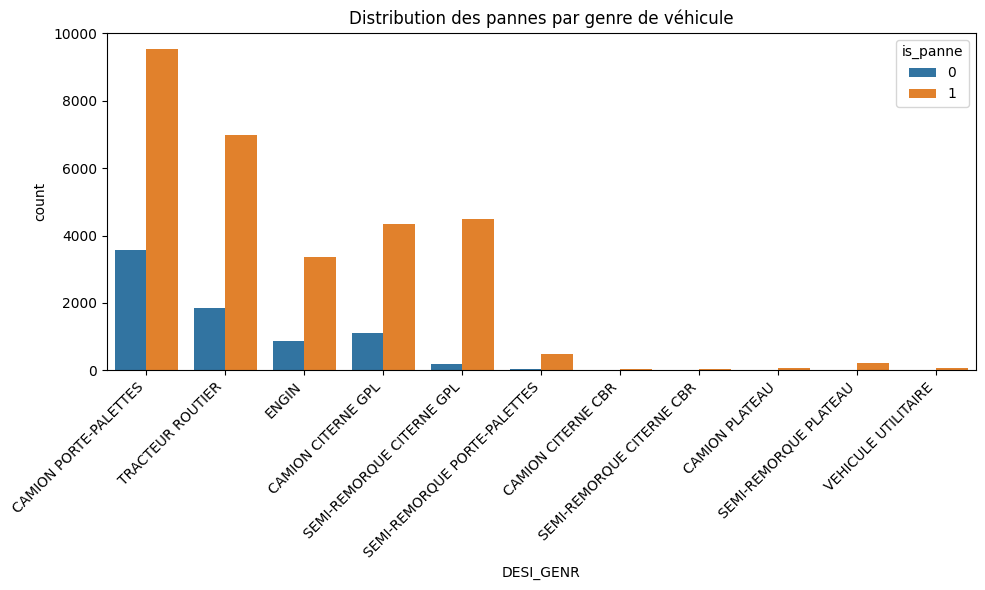

In [96]:
# Visualisation des données
print("\nCréation de visualisations...")

plt.figure(figsize=(10, 6))
sns.countplot(x='DESI_GENR', hue='is_panne', data=df)
plt.title('Distribution des pannes par genre de véhicule')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('pannes_par_genre.png')

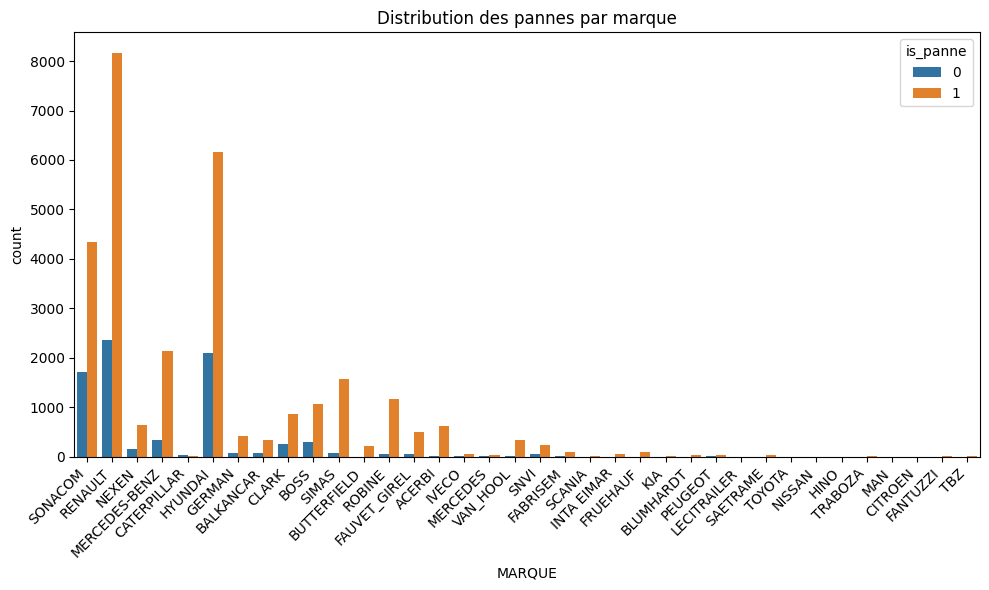

In [97]:
plt.figure(figsize=(10, 6))
sns.countplot(x='MARQUE', hue='is_panne', data=df)
plt.title('Distribution des pannes par marque')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('pannes_par_marque.png')

In [98]:
# Encoder les variables catégorielles
label_encoders = {}
categorical_features = ['MARQUE', 'TYPE', 'GENRE', 'STATUT','DESI_GENR']

for feature in categorical_features:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature].fillna('UNKNOWN'))
    label_encoders[feature] = le
    joblib.dump(le, f"label_encoder_{feature}.joblib")

# Préparer les features
text_features = ['text_description']
categorical_features = ['MARQUE', 'TYPE', 'GENRE', 'STATUT','DESI_GENR']
numerical_features = ['month', 'dayofweek', 'vehicle_age', 'Kilometrage_Total']

In [100]:
df['vehicle_age'].min()

np.float64(1.0)

In [101]:
X = df[text_features + categorical_features + numerical_features]
y = df['is_panne']

In [102]:
# Ajoutez cette analyse juste après df['is_panne'].value_counts()
print("Distribution des classes:")
print(y.value_counts())

# Visualisation du déséquilibre
plt.figure(figsize=(6,4))
sns.countplot(x=df['is_panne'])
plt.title('Distribution des classes (0: Non-panne, 1: Panne)')
plt.savefig('class_distribution.png')
plt.close()

Distribution des classes:
is_panne
1    29659
0     7708
Name: count, dtype: int64


In [103]:
# Split des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [104]:
# Créer le pipeline pour le texte
text_transformer = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000, ngram_range=(1, 2)))
])

# Créer le préprocesseur avec imputation pour les features numériques
preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_transformer, 'text_description'),
        # Apply imputation to numerical features
        ('num', SimpleImputer(strategy='median'), numerical_features),
        # Pass through the already encoded categorical features
        ('cat', 'passthrough', categorical_features)
    ],
    # Set remainder='passthrough' to include other columns if needed, although not strictly necessary here
    # since all columns in X are explicitly handled.
    remainder='passthrough'
)

# Créer le pipeline complet
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ("smote", SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
])

# Validation croisée
# Note: The code below this point should remain the same as in your original notebook
# as it uses the correctly defined pipeline and preprocessor.
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='f1')
print(f"Scores de validation croisée: {cv_scores}")
print(f"Score moyen de validation croisée: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Continue with the rest of your code for fitting the model, prediction, and evaluation.

Scores de validation croisée: [0.91896854 0.92135399 0.92219795 0.91799698 0.90577356]
Score moyen de validation croisée: 0.917 (+/- 0.012)


In [105]:
X.isnull().sum()

text_description         0
MARQUE                   0
TYPE                     0
GENRE                    0
STATUT                   0
DESI_GENR                0
month                    0
dayofweek                0
vehicle_age           3965
Kilometrage_Total    17345
dtype: int64

In [106]:

pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=1000,
                                                                                   ngram_range=(1,
                                                                                                2)))]),
                                                  'text_description'),
                                                 ('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['month', 'dayofweek',
                                                   'vehicle_age',
                                                   'Kilometrage_Total']),
                                                 ('cat', 'passthrough',
                                                  ['MARQUE', 'TYPE', 'GENRE',
                                                   'STATUT', 'DESI_GENR'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [107]:
# Faire des prédictions
y_pred = pipeline.predict(X_test)

In [108]:
# Évaluer le modèle
print("\nRapport de classification:")
print(classification_report(y_test, y_pred, target_names=['non-panne','panne']))


Rapport de classification:
              precision    recall  f1-score   support

   non-panne       0.71      0.74      0.72      1542
       panne       0.93      0.92      0.93      5932

    accuracy                           0.88      7474
   macro avg       0.82      0.83      0.82      7474
weighted avg       0.89      0.88      0.88      7474



In [109]:
# Générer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.savefig('confusion_matrix.png')
plt.close()


In [110]:
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

In [111]:
# Générer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('roc_curve.png')
plt.close()

# Trouver le meilleur seuil
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"\nSeuil optimal pour la classification : {optimal_threshold:.3f}")


Seuil optimal pour la classification : 0.767


In [112]:
# Générer la courbe d'apprentissage
train_sizes, train_scores, test_scores = learning_curve(
    pipeline, X, y, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Score d\'entraînement')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label='Score de validation')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

plt.xlabel('Taille de l\'ensemble d\'entraînement')
plt.ylabel('Score')
plt.title('Courbe d\'apprentissage')
plt.legend(loc='best')
plt.grid(True)
plt.savefig('learning_curve.png')
plt.close()

In [113]:
# Sauvegarder le modèle
joblib.dump(pipeline, 'maintenance_model.joblib')

print("\nLe modèle a été sauvegardé dans 'maintenance_model.joblib'")
print("Les visualisations ont été sauvegardées dans:")
print("- confusion_matrix.png")
print("- learning_curve.png")
print("- roc_curve.png")


Le modèle a été sauvegardé dans 'maintenance_model.joblib'
Les visualisations ont été sauvegardées dans:
- confusion_matrix.png
- learning_curve.png
- roc_curve.png


In [115]:
print(X_train.columns)

Index(['text_description', 'MARQUE', 'TYPE', 'GENRE', 'STATUT', 'DESI_GENR',
       'month', 'dayofweek', 'vehicle_age', 'Kilometrage_Total'],
      dtype='object')


In [118]:
from pydantic import BaseModel

print("class DonneesEntree(BaseModel):")
for col in X_train.columns:
    dtype = X_train[col].dtype
    if dtype == 'object':
        pyd_type = 'str'
    elif 'int' in str(dtype):
        pyd_type = 'int'
    elif 'float' in str(dtype):
        pyd_type = 'float'
    else:
        pyd_type = 'str'  # Fallback par défaut
    print(f"    {col}: {pyd_type}")


class DonneesEntree(BaseModel):
    text_description: str
    MARQUE: int
    TYPE: int
    GENRE: int
    STATUT: int
    DESI_GENR: int
    month: int
    dayofweek: int
    vehicle_age: float
    Kilometrage_Total: float
